In [1]:
import pandas as pd
import numpy as np
import re
import pickle
from sklearn import preprocessing 
from datetime import datetime

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.io as pio
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *

In [3]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [4]:
# Define the color palette (17 colors).
Viridis= ['#440154', '#48186a', '#472d7b', '#424086', '#3b528b', '#33638d', '#2c728e', '#26828e', '#21918c', '#1fa088',
          '#28ae80', '#3fbc73', '#5ec962', '#84d44b', '#addc30','#d8e219', '#fde725']   

In [5]:
# read clean datafile
df = pd.read_csv('data/dataset5.gz', compression='gzip', header=0, sep=',', quotechar='"')
print(df.shape)

(93701, 39)


With this many predictors, overfitting is definitely a risk. We'll use 3 steps to avoid overfit:
* standardize the predictors
* regularization
* kfold cross-validation

In [6]:
df.columns

Index(['device', 'failure', 'ndays', 'attribute2', 'attribute3', 'attribute4',
       'att5', 'att6', 'attribute7', 'S1F0', 'S1F1', 'W1F0', 'W1F1', 'Z1F0',
       'Z1F1', 'attribute2_lag01', 'attribute2_lag02', 'attribute2_lag03',
       'attribute2_lag04', 'attribute3_lag01', 'attribute3_lag02',
       'attribute3_lag03', 'attribute3_lag04', 'attribute4_lag01',
       'attribute4_lag02', 'attribute4_lag03', 'attribute4_lag04',
       'att5_lag01', 'att5_lag02', 'att5_lag03', 'att5_lag04', 'att6_lag01',
       'att6_lag02', 'att6_lag03', 'att6_lag04', 'attribute7_lag01',
       'attribute7_lag02', 'attribute7_lag03', 'attribute7_lag04'],
      dtype='object')

## Create a testing dataset

In [8]:
# Split the data
df_train, df_test = train_test_split(df, test_size = .3, random_state=42)

#### Dealing with imbalanced classes in the training dataset

In [9]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df_train[df_train['failure']==0]
df_minority = df_train[df_train['failure']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_train_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_train_upsampled['failure'].value_counts()
# hat tip: https://elitedatascience.com/imbalanced-classes

1    65524
0    65524
Name: failure, dtype: int64

In [10]:
# final x-values (features)
X_train=df_train_upsampled.drop(['failure', 'device'], axis=1)
X_test=df_test.drop(['failure', 'device'], axis=1)

In [11]:
# final y-values
y_train=df_train_upsampled['failure'].values
y1_test=df_test[['device','failure']] # Hold onto the device variable for later use, but remove it from the modeling data.
y_test=df_test['failure'].values

In [12]:
# confirm that lengths match
assert len(X_train)==len(y_train)
assert len(X_test)==len(y_test)

# Preliminary model exploration

### Naive Bayes Classifier

In [39]:
gnb = GaussianNB()
# Fit on the training data
gnb_model = gnb.fit(X_train, y_train)
# Predict on the testing data
predictions=gnb_model.predict(X_test)
probabilities = gnb_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_nb=metrics.roc_auc_score(y_test, predictions)
acc_nb = metrics.accuracy_score(y_test, predictions)
f1_nb = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_nb,4))
print('Accuracy', "%.4f" % round(acc_nb,4))
print('AUC Score', "%.4f" % round(auc_nb,4))

F1 Score 0.0045
Accuracy 0.7784
AUC Score 0.6693


### Logistic Regression

In [40]:
logreg = LogisticRegression()
# Fit on the training data
log_model=logreg.fit(X_train, y_train)
# Predict on the testing data
predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_log=metrics.roc_auc_score(y_test, predictions)
acc_log = metrics.accuracy_score(y_test, predictions)
f1_log = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_log,4))
print('Accuracy', "%.4f" % round(acc_log,4))
print('AUC Score', "%.4f" % round(auc_log,4))

F1 Score 0.0109
Accuracy 0.8901
AUC Score 0.7852


### KNN Classifier

In [41]:
knn = KNeighborsClassifier(n_neighbors=7)
# Fit on the training data
knn_model=knn.fit(X_train, y_train)
# Predict on the testing data
predictions=knn_model.predict(X_test)
probabilities = knn_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_knn=metrics.roc_auc_score(y_test, predictions)
acc_knn = metrics.accuracy_score(y_test, predictions)
f1_knn = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_knn,4))
print('Accuracy', "%.4f" % round(acc_knn,4))
print('AUC Score', "%.4f" % round(auc_knn,4))

F1 Score 0.0202
Accuracy 0.9965
AUC Score 0.5187


### Random Forest

In [42]:
rf = RandomForestClassifier()
# Fit on the training data
rf_model=rf.fit(X_train, y_train)
# Predict on the testing data
predictions=rf_model.predict(X_test)
probabilities = rf_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_rf=metrics.roc_auc_score(y_test, predictions)
acc_rf = metrics.accuracy_score(y_test, predictions)
f1_rf = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_rf,4))
print('Accuracy', "%.4f" % round(acc_rf,4))
print('AUC Score', "%.4f" % round(auc_rf,4))

F1 Score 0.0000
Accuracy 0.9990
AUC Score 0.4999


### Comparison of Four Models

In [43]:
f1=[f1_nb, f1_log, f1_knn, f1_rf]
acc=[acc_nb, acc_log, acc_knn, acc_rf]
auc=[auc_nb, auc_log, auc_knn, auc_rf]
models=['naive bayes', 'logistic regression', 'k-nearest neighbors', 'random forest']
index=['F1 score', 'Accuracy', 'AUC score']
results=pd.DataFrame([f1, acc, auc], index=index, columns=models)

In [44]:
results.head()

,naive bayes,logistic regression,k-nearest neighbors,random forest
F1 score,0.004476,0.010887,0.020202,0.000000
Accuracy,0.778450,0.890114,0.996549,0.999004
AUC score,0.669322,0.785151,0.518700,0.499947


In [47]:
# Let's display that with plotly.
mydata1 = go.Bar(
    x=results.loc['F1 score'].index,
    y=results.loc['F1 score'],
    name=results.index[0],
    marker=dict(color=Viridis[16])
)
mydata2 = go.Bar(
    x=results.loc['Accuracy'].index,
    y=results.loc['Accuracy'],
    name=results.index[1],
    marker=dict(color=Viridis[10])
)
mydata3 = go.Bar(
    x=results.loc['AUC score'].index,
    y=results.loc['AUC score'],
    name=results.index[2],
    marker=dict(color=Viridis[0])
)
mylayout = go.Layout(
    title='Comparison of Possible Models',
    xaxis = dict(title = 'Predictive models'), # x-axis label
    yaxis = dict(title = 'Score'), # y-axis label
    
)
fig = go.Figure(data=[mydata1, mydata2, mydata3], layout=mylayout)
iplot(fig)

## Looks like we're overfitting

Try optimizing the  model to avoid overfit:
* gridsearch 
* kfold crossvalidation
* test on hold-out dataset

### More results from Random Forest model

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid", color_codes=None)

In [21]:
# Gridsearch to determine optimal hyperparameters
# parameters = {'max_features':np.arange(5,10,len(X.columns)),
#               'n_estimators':[500],
#               'min_samples_leaf': [10,100,500],
#               'max_depths' = np.linspace(1, 32, 32, endpoint=True)
#              }
# grid = GridSearchCV(RandomForestClassifier(), param_grid=parameters, n_jobs = 1, cv = 5)
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [22]:
# Instantiate model using those parameters
# rf_model = grid.best_estimator_
# print(rf_model)

In [23]:
# Full list of metrics
def model_metrics(y_test, predictions):
    '''
    Calculate 5 standard model metrics
    Return a dictionary with the metrics
    '''
    f1 = metrics.f1_score(y_test, predictions)
    accuracy = metrics.accuracy_score(y_test, predictions)
    error = 1 - accuracy
    precision = metrics.precision_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions)
    rocauc =  metrics.roc_auc_score(y_test, predictions)
    return {'f1 score':f1, 'accuracy score': accuracy, 'error rate': error, 'precision score': precision, 'recall score': recall, 'ROC-AUC score': rocauc}


model_metrics(y_test, predictions)

{'f1 score': 0.0,
 'accuracy score': 0.99900394863220798,
 'error rate': 0.00099605136779201686,
 'precision score': 0.0,
 'recall score': 0.0,
 'ROC-AUC score': 0.49994659260841701}

In [24]:
# A confusion matrix tells us our false positives and false negatives:
confusion_matrix(y_test, predictions)

array([[28083,     3],
       [   25,     0]])

In [25]:
# compute the feature importances
importances = rf_model.feature_importances_
std = np.std([rf.feature_importances_ for rf in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [26]:
feat_imp=pd.DataFrame(importances, index=X_test.columns, columns=['importance'])
feat_imp.sort_values('importance', ascending=False)

,importance
attribute4_lag01,0.139326
ndays,0.068857
att6,0.062864
att6_lag02,0.060132
att6_lag03,0.059102
att6_lag04,0.057956
attribute7_lag01,0.052930
attribute4,0.048546
att6_lag01,0.047977
attribute2,0.047917


Text(0,0.5,'Feature Importance')

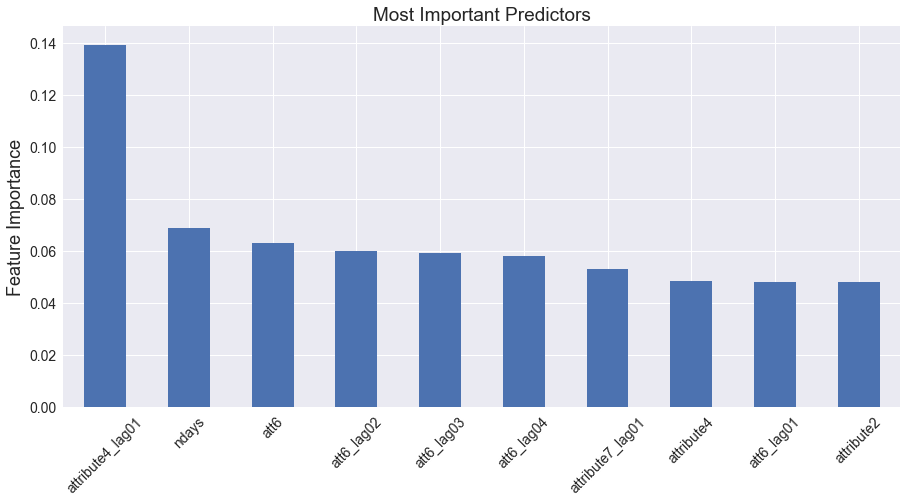

In [27]:
top10=feat_imp['importance'].sort_values(ascending=False).head(10)
# sns.palplot(sns.color_palette("RdBu", n_colors=7))
ax = top10.plot(kind='bar', legend=False, fontsize=18,  figsize=(15, 7))
plt.xticks(rotation = 45,  fontsize=14)
plt.title('Most Important Predictors',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=14)
plt.ylabel('Feature Importance', rotation=90,  fontsize=18) 

#### Were these features highly correlated with the outcome?

In [28]:
cols=list(top10.index)[:5]
cols.append('failure')
cols

['attribute4_lag01', 'ndays', 'att6', 'att6_lag02', 'att6_lag03', 'failure']

In [29]:
df[cols].corr()

,attribute4_lag01,ndays,att6,att6_lag02,att6_lag03,failure
attribute4_lag01,1.000000,-0.031030,0.017859,0.022169,0.020080,0.056897
ndays,-0.031030,1.000000,0.048164,0.111577,0.139195,0.002727
att6,0.017859,0.048164,1.000000,0.900602,0.860148,0.006471
att6_lag02,0.022169,0.111577,0.900602,1.000000,0.955233,0.007418
att6_lag03,0.020080,0.139195,0.860148,0.955233,1.000000,0.007861
failure,0.056897,0.002727,0.006471,0.007418,0.007861,1.000000


#### ROC-AUC

In [30]:
from sklearn.metrics import roc_curve, auc
# Empty dictionaries.
FPR = dict()
TPR = dict()
ROC_AUC = dict()
# For class 1 (has WNV), find the area under the curve:
FPR[1], TPR[1], _ = roc_curve(y_test, probabilities)
ROC_AUC[1] = auc(FPR[1], TPR[1])

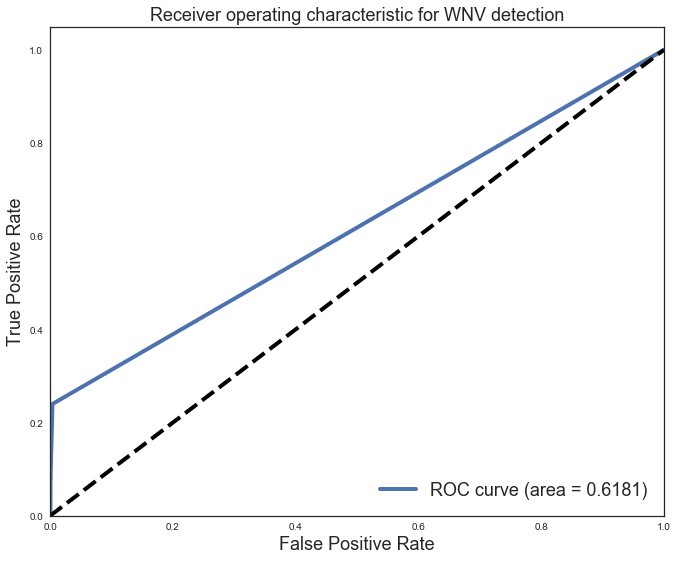

In [31]:
# Let's draw that:
plt.style.use('seaborn-white')
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.4f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for WNV detection', fontsize=18)
plt.legend(loc="lower right", fontsize=18);

## How often are we accurate when aggregated to the device level?

In [33]:
y1_test=y1_test.reset_index(drop=True) # for the concat to work correctly, must have a clean index.
preds_df=pd.DataFrame(predictions, columns=['preds'])
combined_testdf=pd.concat([y1_test, preds_df], axis=1)

print('y_test: ', len(y1_test))
print('probabilities: ', len(preds_df))
print('combined: ', len(combined_testdf))

y_test:  28111
probabilities:  28111
combined:  28111


In [34]:
combined_testdf.head()

,device,failure,preds
0,S1F0S68M,0,0
1,Z1F1R76A,0,0
2,W1F16RA7,0,0
3,S1F131F6,0,0
4,W1F14GTK,0,0


In [35]:
aggdf=combined_testdf.groupby('device')[['device', 'failure', 'preds']].mean().reset_index(drop=False)
print(aggdf.shape)
aggdf.head()

(676, 3)


,device,failure,preds
0,S1F01E6Y,0.000000,0.0
1,S1F01XDJ,0.000000,0.0
2,S1F023H2,0.166667,0.0
3,S1F02L38,0.000000,0.0
4,S1F03YZM,0.012821,0.0


In [36]:
aggdf['failed']=0
aggdf.loc[aggdf['failure']>0, 'failed']=1
aggdf['failed'].value_counts()

0    651
1     25
Name: failed, dtype: int64

In [37]:
aggdf['pred_failed']=0
aggdf.loc[aggdf['preds']>0, 'pred_failed']=1
aggdf['pred_failed'].value_counts()

0    673
1      3
Name: pred_failed, dtype: int64

In [38]:
# Confusion Matrix (device level)
pd.crosstab(aggdf['failed'], aggdf['pred_failed'],  margins=True)

pred_failed,0,1,All
failed,,,
0,648,3,651
1,25,0,25
All,673,3,676
